In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import io
from io import BytesIO
import os

from typing import Dict, List

from google.cloud import vision

from PIL import Image
import requests

from linimage.extractor import Extractor
from linalgo.annotate.models import Document, Annotation, Entity, Target, Annotator
from linalgo.annotate.bbox import BoundingBox
from linalgo.annotate import b_entity, p_entity, s_entity, w_entity
from linalgo.hub.client import LinalgoClient

In [2]:
token = os.getenv('LINHUB_TOKEN')
client = LinalgoClient(token=token, api_url='https://linhub.api.linalgo.com/v1')
task = client.get_task('f753184d-2dd0-4dfb-adba-f9a552d3b083', verbose=True)

Retrivieving task with id f753184d-2dd0-4dfb-adba-f9a552d3b083...
Retrieving annotators... (2 found)
Retrieving entities... (6 found)
Retrieving documents... (29 found)
Retrieving annotations... (3324 found)


In [4]:
def add_ocr_annotations(doc: Document, ocr_annotations) -> List[Dict]:
    """
    Extract bounding boxes using Google Vision API

    :param doc: Document to annotate
    :param response: Google Vision API full_text response
    :return:
    """
    annotator = Annotator(name='google-ocr')
    for page in ocr_annotations.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    text = ''
                    for s in word.symbols:
                        text += s.text
                        v = s.bounding_box.vertices
                        t = Target(selectors=[BoundingBox.fromVertices(v)])
                        Annotation(entity=s_entity, document=doc,
                                   body=s.text, target=t, annotator=annotator)
                    v = word.bounding_box.vertices
                    t = Target(selectors=[BoundingBox.fromVertices(v)])
                    Annotation(entity=w_entity, document=doc,
                               body=text, target=t, annotator=annotator)
                v = paragraph.bounding_box.vertices
                t = Target(selectors=[BoundingBox.fromVertices(v)])
                Annotation(entity=p_entity, document=doc, body='', target=t,
                           annotator=annotator)
            v = block.bounding_box.vertices
            t = Target(selectors=[BoundingBox.fromVertices(v)])
            Annotation(entity=b_entity, document=doc, body='', target=t,
                       annotator=annotator)
    return doc


os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'YOU_JSON_CRED_FILE'


def ocr(doc: Document):

    response = requests.get(doc.content)
    img = BytesIO(response.content)
    client = vision.ImageAnnotatorClient()
    image = vision.types.Image(content=img.read())
    response = client.text_detection(image=image)
    return add_ocr_annotations(doc, response.full_text_annotation)

In [5]:
doc = task.documents[0]
ocr_doc = ocr(doc)

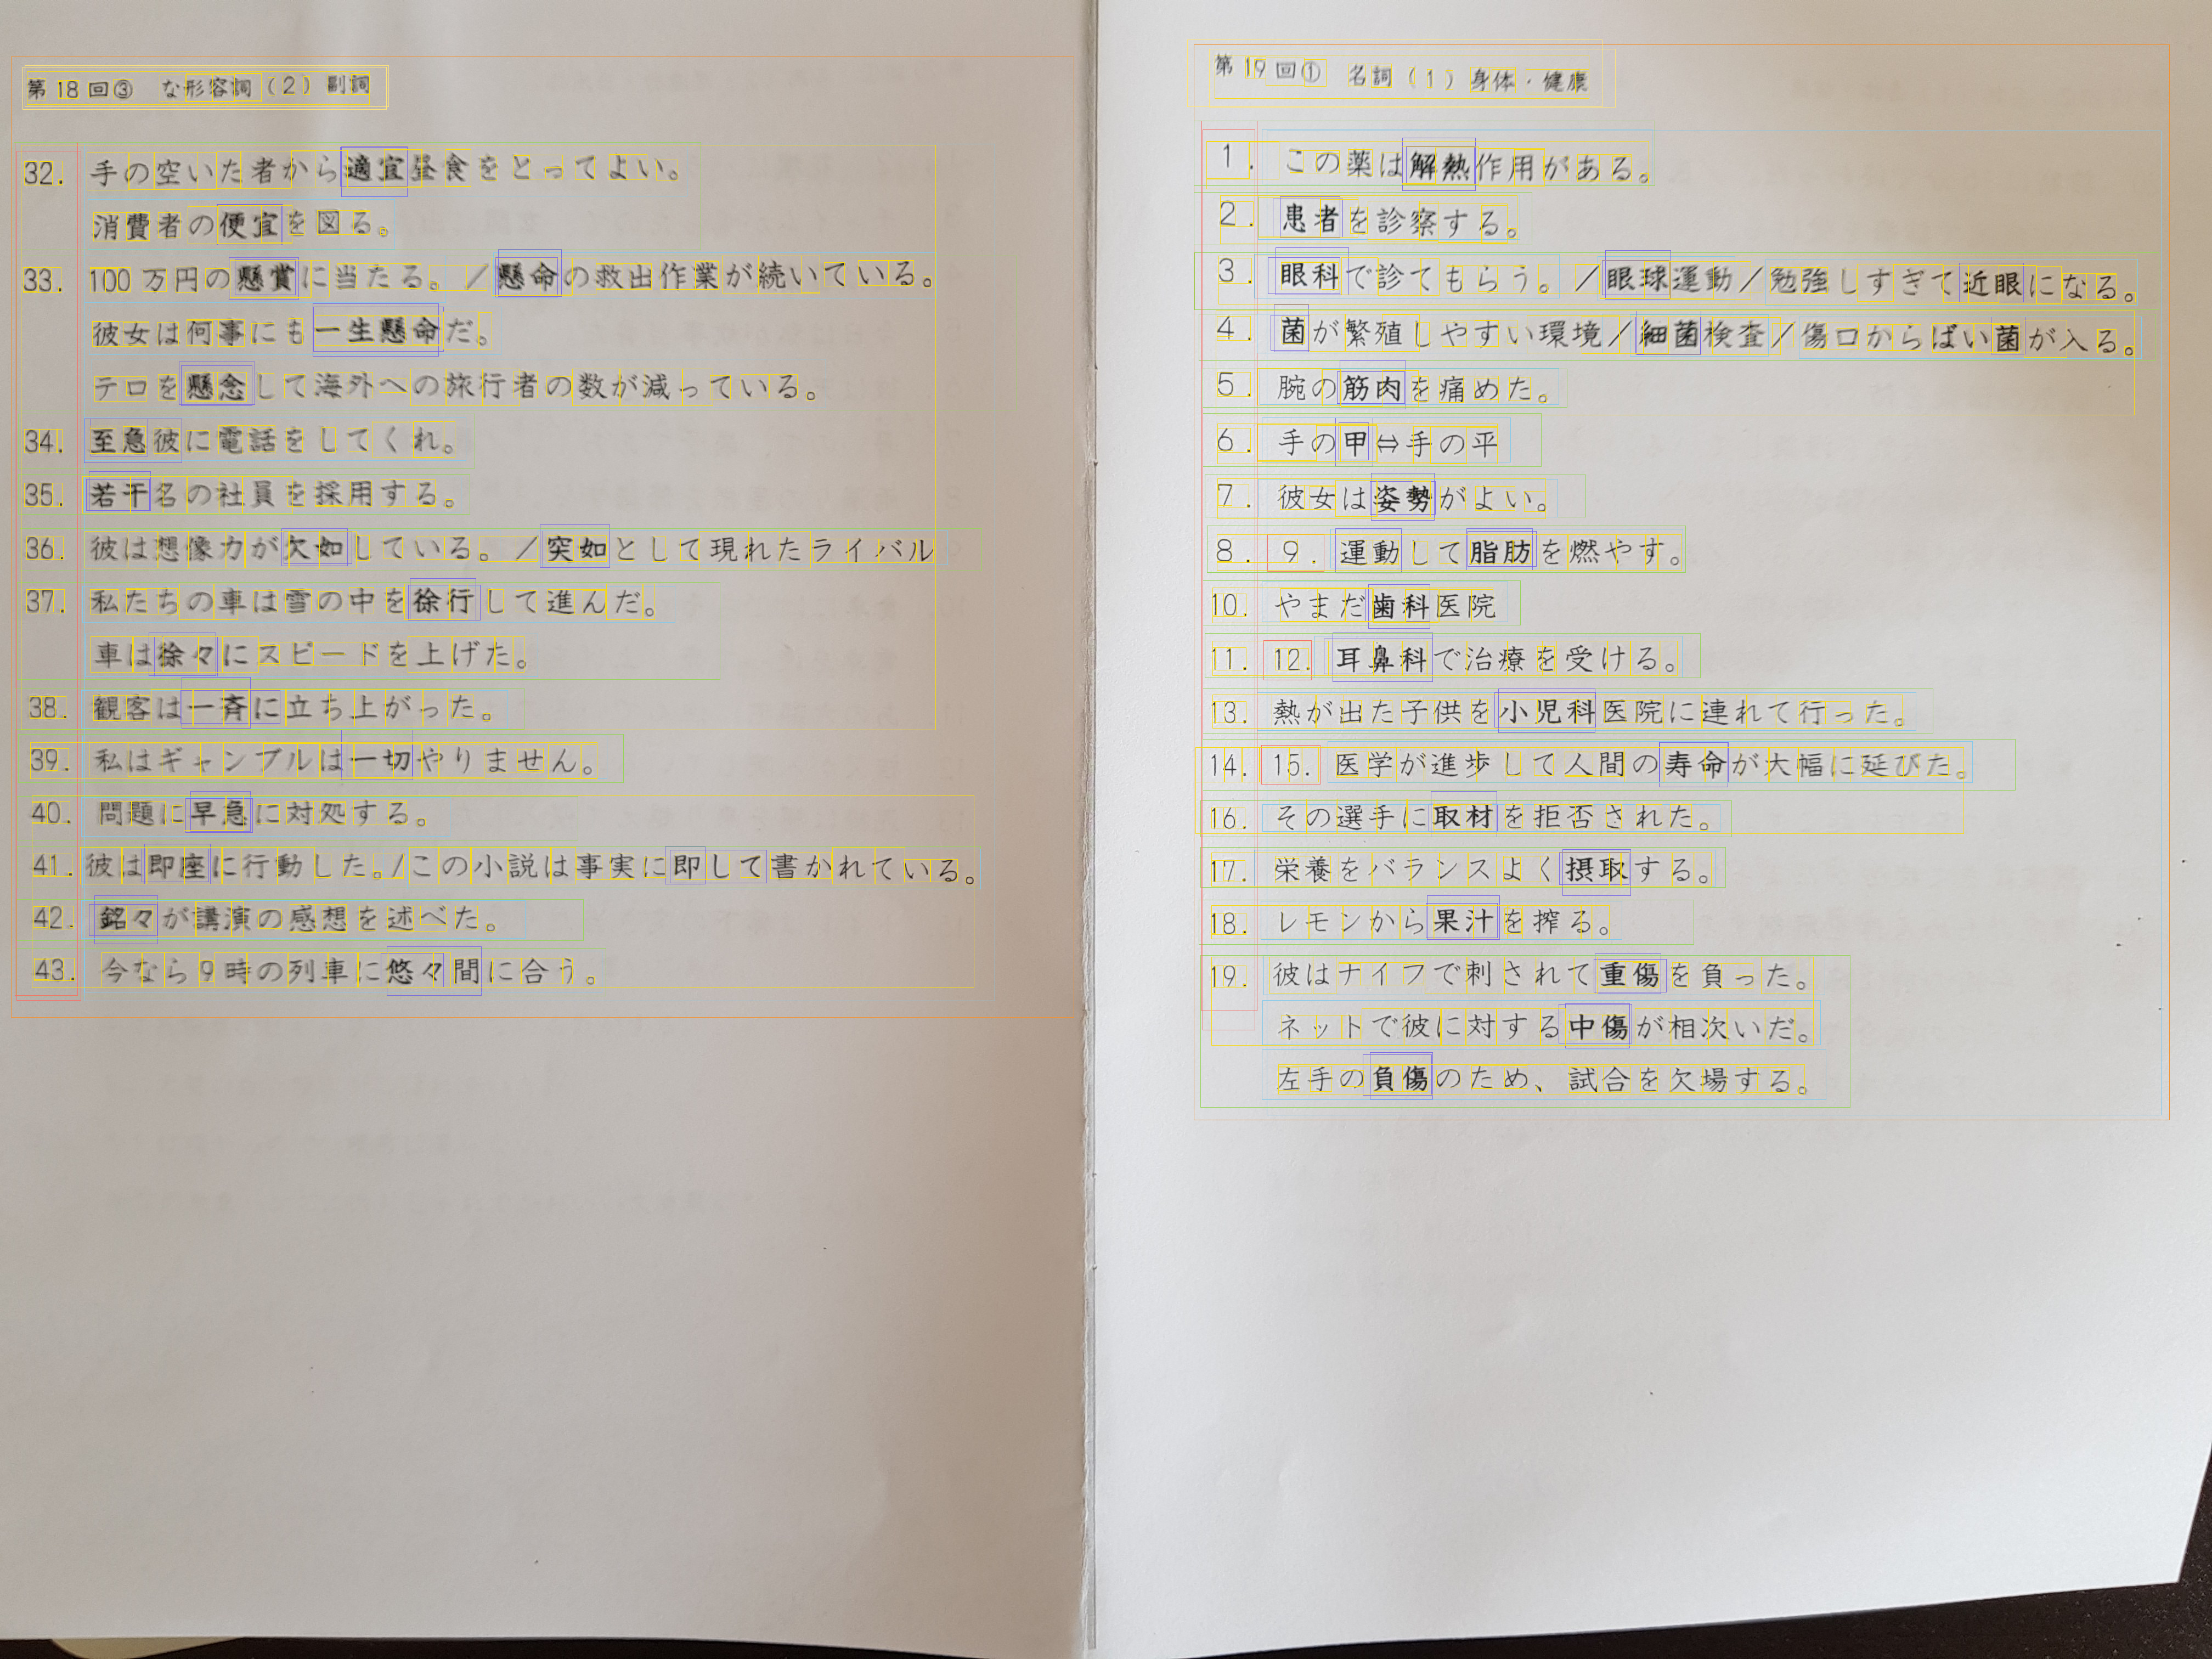

In [6]:
import requests, io
from linalgo.annotate.bbox import draw_bounding_boxes
from PIL import Image

response = requests.get(ocr_doc.content)
img = Image.open(io.BytesIO(response.content))
draw_bounding_boxes(img, doc.annotations)

In [30]:
set(a.entity.name for a in doc.annotations)

{'BLOCK', 'Item', 'PARAGRAPH', 'Page', 'SYMBOL', 'WORD', '例文', '数', '第', '言葉'}

In [26]:
a1 = doc.annotations[0]
b1 = a1.target.selectors[0]
a2 = doc.annotations[100]
b2 = a2.target.selectors[0]
print(a1, b1)
print(a2, b2)

Annotation::言葉 {(2429.4802716344675, 1153.7061064421048), (2611.457108176646, 1153.7061064421048), (2611.457108176646, 1242.0948556197345), (2429.4802716344675, 1242.0948556197345)}
Annotation::例文 {(2396.412473341308, 1159.0292571836767), (3066.1147928266087, 1159.0292571836767), (3066.1147928266087, 1235.1317934888245), (2396.412473341308, 1235.1317934888245)}


In [29]:
b1.intersects(b2)

True

In [21]:
b1.overlap(b2)

0.8609980004605451

In [28]:
b3 = b1.intersection(b2)
b3

{(2429.4802716344675, 1159.0292571836767), (2611.457108176646, 1159.0292571836767), (2611.457108176646, 1235.1317934888245), (2429.4802716344675, 1235.1317934888245)}

In [33]:
task.annotators

[Annotator::estelled, Annotator::arnaud]